In [430]:
# 初始化参数
import librosa


n_fft = 256
hop_length = 16
win_length = 256
Fs = 16000
# 设置待降噪路径
noisy_path = "TestData\mixed_5dB.wav"
noisy, _ = librosa.load(noisy_path, sr=Fs)

In [431]:
import torch
from DeepFIR.DeepFIR import LstmWin
from util.utils import prepare_device
# 加载检查点
Tar_Path = 'DeepFIR\\best_model.tar'
model_checkpoint = torch.load(Tar_Path, weights_only=False)  # 现在不会报错
model_static_dict = model_checkpoint["model"]
# 实例化模型（需确保参数与训练时一致）
model = LstmWin()  # 替换为你的实际参数
model.load_state_dict(model_static_dict)  # 加载参数

# 选择设备
device = prepare_device(torch.cuda.device_count())
model.to(device)
model.eval()

LstmWin(
  (lstm_layer_1): LSTM(129, 200, batch_first=True)
  (lstm_layer_2): LSTM(200, 200, batch_first=True)
  (fc_layer): Sequential(
    (0): Linear(in_features=200, out_features=129, bias=True)
    (1): ReLU()
    (2): Linear(in_features=129, out_features=129, bias=True)
    (3): Sigmoid()
  )
)

In [432]:
noisy_mag, noisy_phase = librosa.magphase(librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length, win_length=win_length))
noisy_mag = torch.tensor(noisy_mag, device=device)[None, :, :]  # [F, T] => [1, F, T]
enhanced_FIR_Taps = model(noisy_mag)
enhanced_mag = noisy_mag * enhanced_FIR_Taps
enhanced_mag = enhanced_mag.squeeze(0).detach().cpu().numpy()  # [1, F, T] => [F, T]

In [433]:
# # 用自带逆变换回复
# enhanced = librosa.istft(enhanced_mag * noisy_phase, hop_length=hop_length, win_length=win_length, length=len(noisy))

In [434]:
# # 尝试1.直接每一帧逆变换并且除了第一帧其余帧只留下最后hop_length长度的时域数据（发现直接以这种方式会导致无法完美重建信号）
# # 将幅度谱和相位谱组合为复数频谱
# import numpy as np
# D = enhanced_mag * noisy_phase
# # 1. 对每一帧进行逆FFT
# frames = np.fft.irfft(D, n=n_fft, axis=0)  # 逆FFT，得到时域帧
# # 2. 处理时域帧
# processed_frames = []
# for i in range(frames.shape[1]):  # 遍历每一帧
#     if i == 0:
#         # 保留第一帧的全部数据
#         processed_frames.append(frames[:, i])
#     else:
#         # 只保留最后 hop_length 长度的数据
#         processed_frames.append(frames[-hop_length:, i])
# # 3. 重叠相加重构信号
# enhanced = np.zeros(hop_length * (len(processed_frames) - 1) + len(processed_frames[0]))
# for i, frame in enumerate(processed_frames):
#     start = i * hop_length
#     end = start + len(frame)
#     enhanced[start:end] += frame

In [435]:
# 尝试2.直接IFFT后用矩形窗合并（效果很不错）
# 将幅度谱和相位谱组合为复数频谱
import numpy as np
import librosa
D = enhanced_mag * noisy_phase
# 1. 对每一帧进行逆FFT
frames = np.fft.irfft(D, n=n_fft, axis=0)  # 逆FFT，得到时域帧
frames = frames
# 2. 处理时域帧
processed_frames = []
for i in range(frames.shape[1]):  # 遍历每一帧
    processed_frames.append(frames[:, i])
# 3. 重叠相加重构信号
enhanced = np.zeros(hop_length * (len(processed_frames) - 1) + len(processed_frames[0]))
for i, frame in enumerate(processed_frames):
    start = i * hop_length
    end = start + len(frame)
    enhanced[start:end] += frame


In [436]:
# 画图展示
from matplotlib import pyplot as plt
import numpy as np
import IPython.display as ipd
def Plot_AudioData(enhanced,title,Fs):
    enhanced_mag, _ = librosa.magphase(librosa.stft(enhanced, n_fft=320, hop_length=160, win_length=320))
    # 转换为分贝（dB）尺度
    enhanced_mag_db = librosa.amplitude_to_db(enhanced_mag, ref=20)
    # 绘制时频图
    plt.figure(figsize=(13, 5))
    librosa.display.specshow(enhanced_mag_db, sr=Fs, hop_length=160, x_axis='time', y_axis='linear', cmap='magma')
    # 添加颜色条
    plt.colorbar(format='%+2.0f dB')
    # 设置标题和标签
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # 显示图像
    plt.show()
    plt.figure(figsize=(13, 5))
    plt.plot(enhanced)
    plt.title("Time")
    plt.show()
    # 显示音频播放
    ipd.display(ipd.Audio(enhanced, rate=Fs))

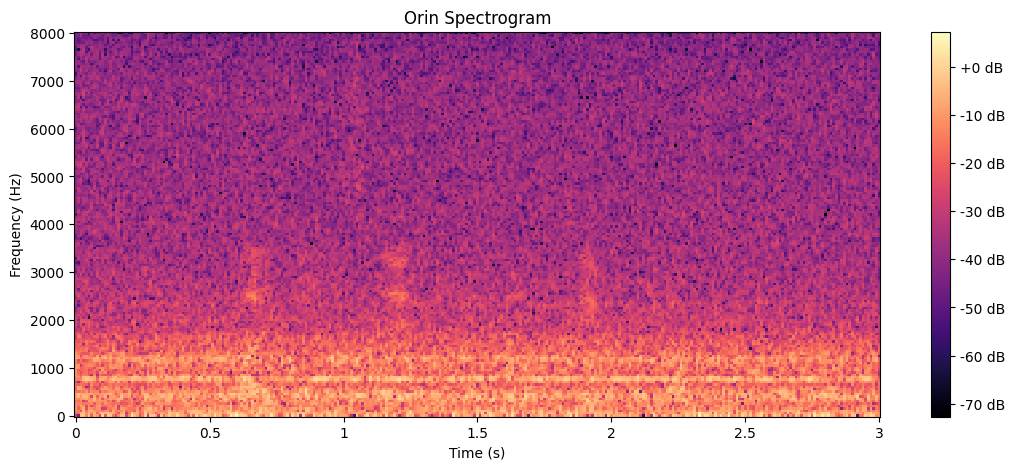

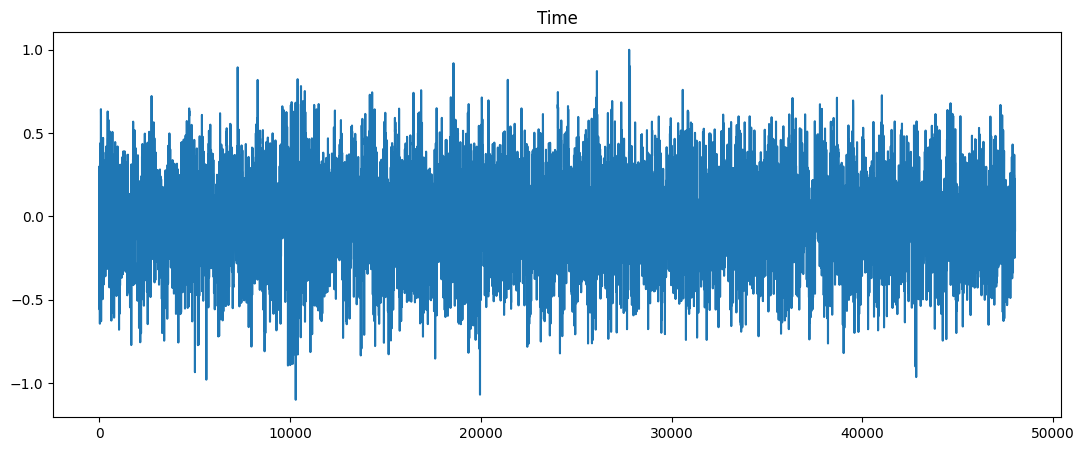

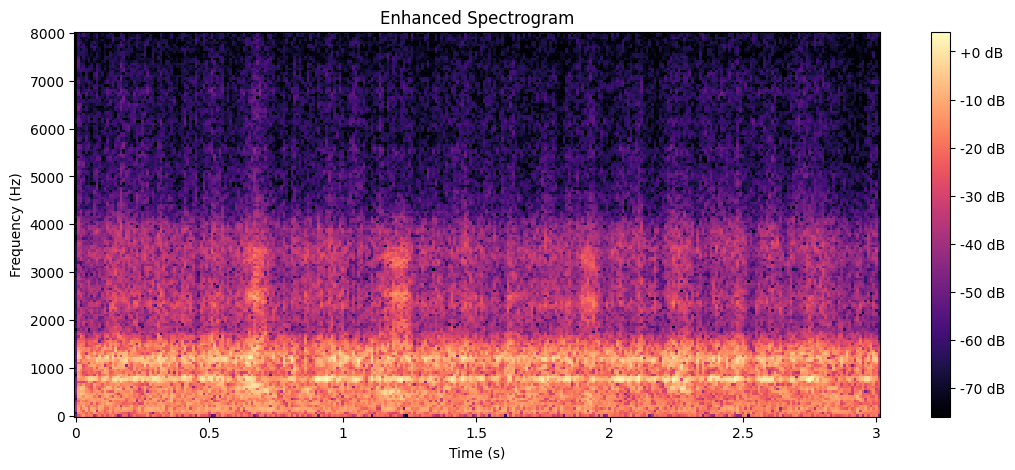

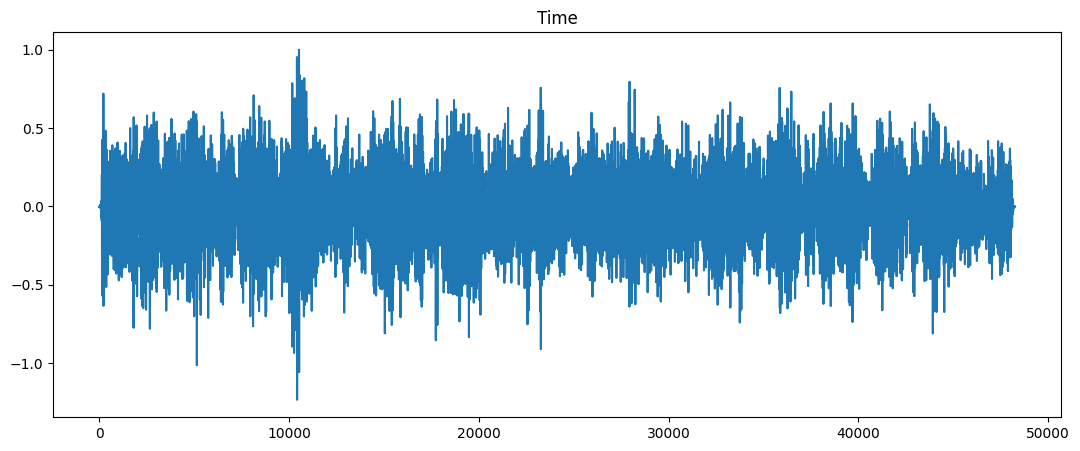

In [437]:
# 先画出原始音频
noisy = noisy/max(noisy)
Plot_AudioData(noisy,'Orin Spectrogram',Fs)
# 再画出增强音频
enhanced = enhanced/max(enhanced)
Plot_AudioData(enhanced,'Enhanced Spectrogram',Fs)

In [438]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hanning_windows(frames_Num, hop_length, win_length):
    """
    绘制多个汉宁窗及其叠加结果
    
    参数:
        frames_Num (int): 总帧数
        hop_length (int): 帧移长度（采样点数）
        win_length (int): 窗函数长度
    """
    # 生成汉宁窗
    hanning_window = np.hanning(win_length)*0.125
    
    # 计算总时间长度
    total_length = (frames_Num - 1) * hop_length + win_length
    
    # 初始化存储矩阵和叠加结果
    window_matrix = np.zeros((frames_Num, total_length))
    sum_signal = np.zeros(total_length)
    
    # 生成每个窗口
    for i in range(frames_Num):
        start = i * hop_length
        end = start + win_length
        window_matrix[i, start:end] = hanning_window
        sum_signal[start:end] += hanning_window
    
    # 创建画布
    plt.figure(figsize=(12, 6))
    
    # 绘制所有窗口
    plt.subplot(2, 1, 1)
    for i in range(frames_Num):
        plt.plot(window_matrix[i], alpha=0.5, label=f'Window {i+1}' if i < 3 else "")
    plt.title(f'{frames_Num} Hanning Windows (hop={hop_length}, win={win_length})')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper right')
    
    # 绘制叠加结果
    plt.subplot(2, 1, 2)
    plt.plot(sum_signal, 'r-', linewidth=2)
    plt.title('Sum of All Windows')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

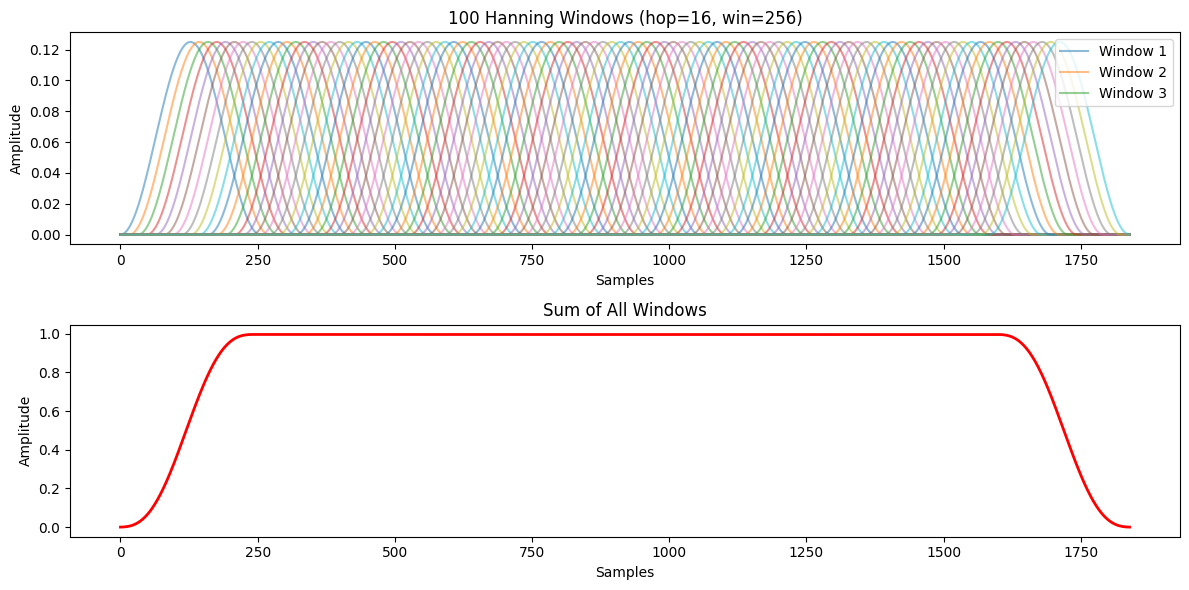

In [439]:
frames_Num = frames.shape[1]
plot_hanning_windows(100, hop_length, win_length)